In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2

%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
import glob
from sklearn import model_selection
from Model.config import Config
import Model.utils
import Model.model as modellib
from Model import visualize
from Model.model import log


# Root directory of the project
# ROOT_DIR = os.getcwd()
ROOT_DIR = '/host'
os.chdir(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

MODEL_NIR_PATH = os.path.join(ROOT_DIR,"Weights/mask_rcnn_irises_ND.h5" )
MODEL_VIS_PATH = os.path.join(ROOT_DIR,"Weights/mask_rcnn_irises_Ubiris.h5" )

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class irisConfig(Config):
    
    
    # Give the configuration a recognizable name
    NAME = "irises"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    NUM_CLASSES = 1 + 1  # background + 3 shapes

    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 50
    


class InferenceConfig(irisConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()
model_nir = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_vis = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

#Loads weights from a static model file

print("Loading NIR model")
model_nir.load_weights(MODEL_NIR_PATH, by_name=True)

print("Loading VIS model")
model_vis.load_weights(MODEL_VIS_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           irises
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS

In [3]:
model_nir.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

8
['/host/b/NIR/0141_06.tiff', '/host/b/NIR/0920_02.tiff', '/host/b/NIR/1170_04.tiff', '/host/b/NIR/1220_07.tiff', '/host/b/NIR/1480_04.tiff', '/host/b/VIS/0480_02.tiff', '/host/b/VIS/1281_04.tiff', '/host/b/VIS/1550_05.tiff']
Saving in /host
0141_06.tiff
0920_02.tiff
1170_04.tiff
1220_07.tiff
1480_04.tiff
0480_02.tiff
1281_04.tiff
1550_05.tiff
Average time per image: 3.1823038458824158


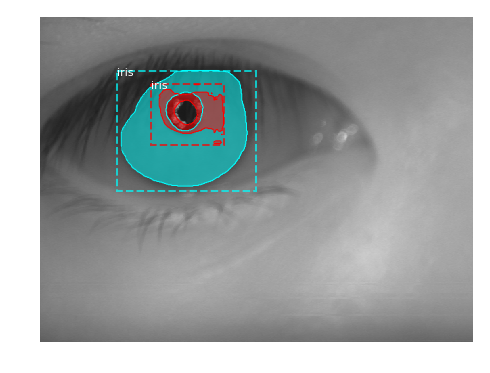

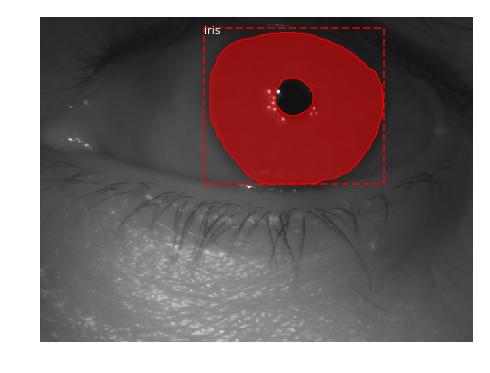

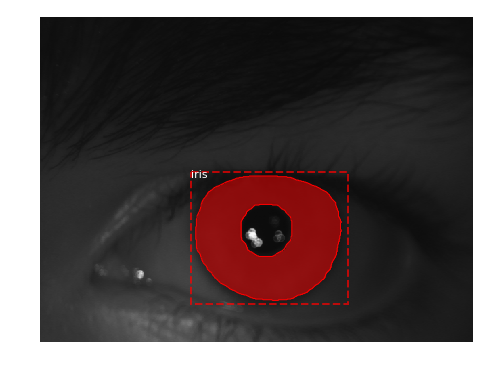

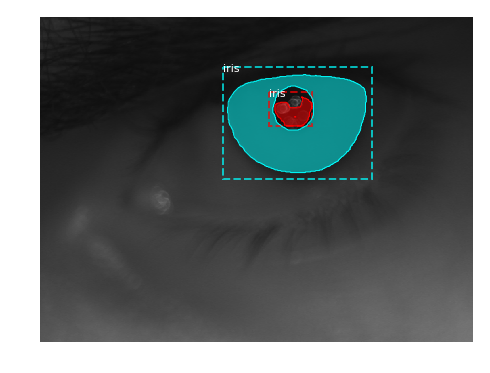

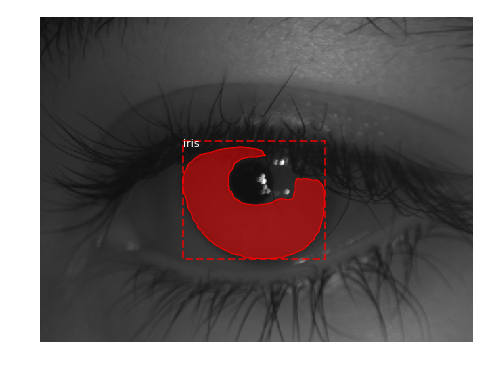

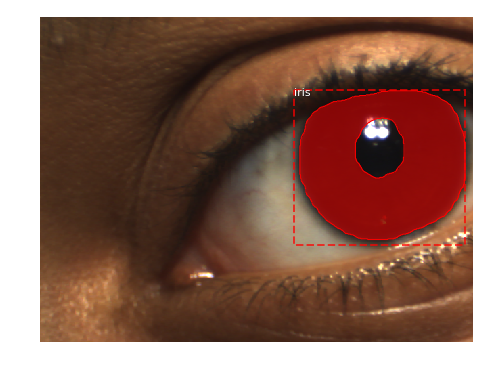

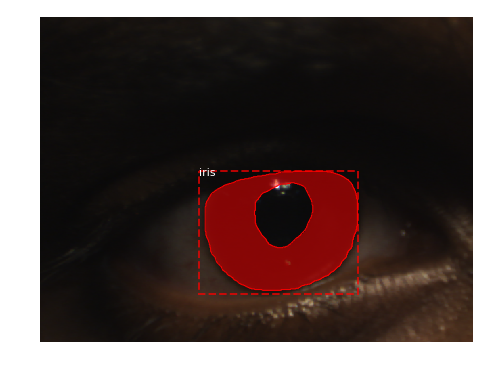

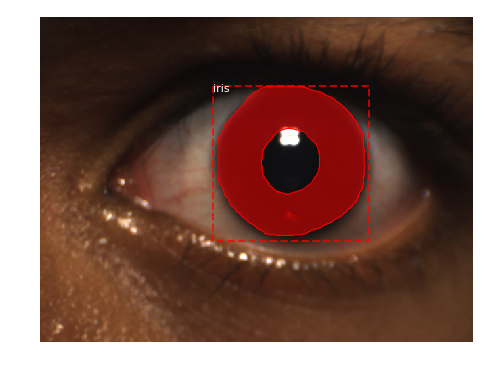

In [6]:
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn import model_selection
import re
from scipy import ndimage
import skimage.io
from PIL import Image
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb
import time
from Model.visualize import display_images,display_weight_stats
import Model.utils as utils

class_names = ['BG','iris']

# Root directory of the project

# Load images from folder

numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def find_tiff_files(directory):
    tiff_files = []
    
    # Walk through all the subdirectories and files
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.tiff') or file.lower().endswith('tif'):
#                 path = os.path.relpath(os.path.join(root, file), start=directory)
                path = os.path.join(root, file)
                
                tiff_files.append(path)
    
    return tiff_files


#Inference one at a time, change to batch (Memory per image calculate)
def runonFolder(imList,segmFolder,maskFolder,centered):
    
    
    print (  len(imList))
    print(imList)

    
    avgTime = 0.0
    
#     irisFolder = saveFolder
#     if not os.path.exists(irisFolder):
#         os.makedirs(irisFolder)
        
#     if not os.path.exists(maskFolder):
#         os.makedirs(maskFolder)
#     os.chdir(irisFolder)

    

    start = time.time()

    print ("Saving in " + os.getcwd())
    for i in range(len(imList)):
#     for i in range(5):

        try:
            im = imread(imList[i])
            im = skimage.color.gray2rgb(im)

            # Resizing of the image
            # im, window, scale, padding, crop = utils.resize_image(
            # image,
            # min_dim=inference_config.IMAGE_MIN_DIM,
            # min_scale=inference_config.IMAGE_MIN_SCALE,
            # max_dim=inference_config.IMAGE_MAX_DIM,
            # mode="pad64")

            if "NIR" in imList[i]:
                results = model_nir.detect([im], verbose=0)
    #             print("Using NIR model")
            else:
                results = model_vis.detect([im], verbose=0)
    #             print("Using VIS model")

            r = results[0]
            mask = r['masks'][:, :, 0]


            saveSubPath = os.path.join(*imList[i].split("/")[3:-1])
            saveName = imList[i].split("/")[-1]

            saveName = re.sub('[.].*','.tiff',saveName)

            print(saveName)

            mask = r['masks'][:, :, 0]
            bbox = r['rois'][0]
    #             print (bbox)


            # Processing with the centered option
            if centered:
                # Get the bounding box coordinates
                bbox = r['rois'][0]
                cx = ((bbox[0] + bbox[2]) // 2)
                cy = ((bbox[1] + bbox[3]) // 2)
                PADDING = 20

                # Crop the mask and the image based on the bounding box
                croppedMask = mask[bbox[0] - PADDING:bbox[2] + PADDING, bbox[1] - PADDING:bbox[3] + PADDING]
                croppedIm = im[bbox[0] - PADDING:bbox[2] + PADDING, bbox[1] - PADDING:bbox[3] + PADDING]

                # Perform bitwise AND between image and cropped mask to isolate the region
                tIm = croppedIm[:, :, 0]
                croppedMask = croppedMask * 255
                anded = np.bitwise_and(tIm, croppedMask)
    #             matplotlib.image.imsave(saveName, anded)


            if not centered:
                # If not centered, use the whole image and mask
                tIm = im[:, :, 0]
                mask = mask * 255
                anded = np.bitwise_and(tIm, mask)
    #             matplotlib.image.imsave(saveName, anded)


            segmPath = os.path.join(segmFolder, saveSubPath)
            os.makedirs(segmPath, exist_ok=True)            

    #         try:
            matplotlib.image.imsave(os.path.join(segmPath,saveName), anded)
    #         except Exception as e:
    #             print("Error saving " + saveName + ": " + str(e) )
    #             print(anded)


            # Process and save the mask image without displaying it
            saveName = re.sub('[.].*', '.png', saveName)

            # Commenting out the line that visualizes and displays the image
            visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], class_names, show_bbox=True, ax=get_ax())

            maskPath = os.path.join(maskFolder, saveSubPath)
            os.makedirs(maskPath, exist_ok=True)

            # print(mask.shape)
            # print(r['masks'].shape)
            # print(im.shape)

            matplotlib.image.imsave(os.path.join(maskPath, saveName), mask)
        
        except Exception as e:
            with open('logfile.log', 'a') as log_file:
                log_file.write("Exception with file {}. occurred: {}\n".format(saveName, e))

    end = time.time()
    # Print the average processing time
    print("Average time per image: " + str((end-start)/ len(imList)))

#Folder containing iris images
folderPath = ROOT_DIR+"/b"


imList = find_tiff_files(folderPath)

#Segmented masks stored in /segmented
runonFolder(imList,ROOT_DIR+"/segmented",ROOT_DIR+"/masks",centered = 0)

